# Exploratory Data Analysis of PRs on Taxonomy repo

tl;dr if you dont want to read through the entire notebook
# Summary of Results

### QnA YAML Files in PRs
- Mean number of qna.yaml files added in each PR: 1.770
- Median number of qna.yaml files added in each PR: 1.0

### PR Statistics
- Total PRs collected from Taxonomy repo: 305
- PRs adding only one qna.yaml: 210
- PRs adding more than one qna.yaml: 13
- Average size of PRs (lines : additions + deletions) adding only one qna.yaml: 80.78
- Average size of PRs  (lines : additions + deletions) adding more than one qna.yaml: 835.31

### Across all the PRs, the common directories that have been modifed
- compositional_skills: 260
- knowledge: 5
- technical_skills: 1

### Modified Files
- 'compositional_skills' folder: 530
- 'freeform' subdirectory: 281
- 'grounded' subdirectory: 81
- 'knowledge' folder: 11

## Open PRs
- Total open PRs: 211
- Open PRs with approvals: 6

#### Open PRs - Count of Approvals:
- 3 approvals: 2
- 2 approvals: 2
- 5 approvals: 1
- 1 approval: 1

#### Open PRs - Count of Review Comments:
- 1 review comment: 49
- 2 review comments: 18
- 4 review comments: 6
- 3 review comments: 13
- 5 review comments: 2
- 6 review comments: 2
- 11 review comments: 1

## Merged PRs
- Total merged PRs: 56
- Merged PRs with approvals: 4

#### Merged PRs - Count of Approvals:
- 4 approvals: 1
- 10 approvals: 1
- 6 approvals: 1
- 2 approvals: 1

#### Merged PRs - Count of Review Comments:
- 1 review comment: 14
- 4 review comments: 3
- 2 review comments: 2
- 5 review comments: 1
- 3 review comments: 1

### PRs that are either approved or merged and contributing knowledge or skills (not documentation or other stuff)
- Number of PRs we found : 10

In [43]:
from github import Github
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv
from genai import Credentials, Client
from genai.text.generation import TextGenerationParameters
from genai.text.tokenization import (
    TextTokenizationParameters,
    TextTokenizationReturnOptions,
    TextTokenizationCreateResults,
)

load_dotenv()

api_key = os.getenv("GENAI_KEY", None)
api_endpoint = os.getenv("GENAI_API", None)
creds = Credentials(api_key=api_key, api_endpoint=api_endpoint)
client = Client(credentials=creds)

In [51]:
## TODO: From the final dataset we create in this notebook, use a model (merlinite or simple classifier) and a 
# simple prompt to classify it as a knowledge, skill (freeform or grounded)

In [33]:
github_token = os.getenv("GITHUB_TOKEN", None)
repo_owner = 'instruct-lab'
repo_name = 'taxonomy'

g = Github(github_token)

repo = g.get_repo(f"{repo_owner}/{repo_name}")

In [65]:
titles = []
bodies = []
sizes = []
created_by = []
created_at = []
closed_at = []
closed_by = []
merged_at = []
commits_number = []
changed_files_number = []
interactions = []
reviews = []
labels = []
commits = []
changed_files = []

pulls = repo.get_pulls(state='all')

for pull in pulls:
    titles.append(pull.title)
    bodies.append(pull.body)
    sizes.append(pull.additions + pull.deletions)
    created_by.append(pull.user.login)
    created_at.append(pull.created_at)
    closed_at.append(pull.closed_at)
    closed_by.append(pull.user.login if pull.state == 'closed' else None)
    merged_at.append(pull.merged_at)
    commits_number.append(pull.commits)
    changed_files_number.append(pull.changed_files)
    interactions.append(pull.comments + pull.review_comments)
    reviews.append(pull.review_comments)
    labels.append([label.name for label in pull.labels])
    
    pull_commits = pull.get_commits()
    commits.append([commit.sha for commit in pull_commits])
    pull_files = pull.get_files()
    changed_files.append([file.filename for file in pull_files])

data = {
    'title': titles,
    'body': bodies,
    'size': sizes,
    'created_by': created_by,
    'created_at': created_at,
    'closed_at': closed_at,
    'closed_by': closed_by,
    'merged_at': merged_at,
    'commits_number': commits_number,
    'changed_files_number': changed_files_number,
    'interactions': interactions,
    'reviews': reviews,
    'labels': labels,
    'commits': commits,
    'changed_files': changed_files
}

df = pd.DataFrame(data)

In [107]:
len(df)

305

In [ ]:
df.head()

In [5]:
df["reviews"]

0       0
1       0
2       0
3       0
4       0
       ..
300     0
301    12
302     0
303     0
304     8
Name: reviews, Length: 305, dtype: int64

In [6]:
df["labels"]

0                   []
1                   []
2                   []
3                   []
4                   []
            ...       
300                 []
301    [triage-needed]
302                 []
303                 []
304            [skill]
Name: labels, Length: 305, dtype: object

In [23]:
df["size"]

0       18
1      178
2       63
3       63
4       19
      ... 
300     34
301     84
302    175
303      7
304     36
Name: size, Length: 305, dtype: int64

In [7]:
print(len(df["changed_files"]))
df["changed_files"][0:10]

305


0    [compositional_skills/extraction/inference/qua...
1    [compositional_skills/writing/freeform/technic...
2    [compositional_skills/writing/freeform/technic...
3    [compositional_skills/writing/freeform/technic...
4    [compositional_skills/extraction/inference/qua...
5    [compositional_skills/writing/freeform/technic...
6    [compositional_skills/writing/freeform/zodiac/...
7    [compositional_skills/writing/grounded/editing...
8    [compositional_skills/writing/freeform/social_...
9    [writing/freeform/shopping/shopping_recipes.yaml]
Name: changed_files, dtype: object

## Get how many qna.yaml files are added in each PR across PRs

In [18]:
df['qna_yaml_count'] = df['changed_files'].apply(lambda files: sum(1 for file in files if file.endswith('qna.yaml')))

df['other_files_count'] = df['changed_files'].apply(lambda files: sum(1 for file in files if not file.endswith('qna.yaml')))

In [19]:
df.head()

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,qna_yaml_count,other_files_count
0,Added a fibonacci skill,**Describe the contribution to the taxonomy**\...,18,rokkbert,2024-03-11 14:14:00+00:00,NaT,None,NaT,1,1,0,0,[],[8f431a034c6c43352967f03c493315843f54a1d6],[compositional_skills/extraction/inference/qua...,1,0
1,Add instructions how to write devstack plugins,**Describe the contribution to the taxonomy**\...,178,slawqo,2024-03-11 13:53:28+00:00,NaT,None,NaT,1,1,0,0,[],[70ec61de11fd965d79589b704d22ef86df606954],[compositional_skills/writing/freeform/technic...,1,0
2,Support exceptions def,If your PR is related to a contribution to the...,63,r2munz,2024-03-11 13:44:08+00:00,NaT,None,NaT,5,1,0,0,[],"[f6d10ba52de5bf854aabd483745d2e3794cc49fc, 98c...",[compositional_skills/writing/freeform/technic...,1,0
3,Support exceptions def,If your PR is related to a contribution to the...,63,r2munz,2024-03-11 13:39:55+00:00,2024-03-11 13:42:03+00:00,r2munz,NaT,5,1,0,0,[],"[f6d10ba52de5bf854aabd483745d2e3794cc49fc, 98c...",[compositional_skills/writing/freeform/technic...,1,0
4,Add new skill - character counting,If your PR is related to a contribution to the...,19,jridky,2024-03-11 13:30:58+00:00,NaT,None,NaT,1,1,1,0,[],[aa24b5ce992b7bc43c047df9e2e3b2267c968c68],[compositional_skills/extraction/inference/qua...,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,docs: add review process,None,34,xukai92,2024-02-28 16:27:17+00:00,2024-02-28 19:20:20+00:00,xukai92,2024-02-28 19:20:20+00:00,3,3,3,0,[],"[4a281911eb04aa4d07f25d922228b9ed72b296df, f01...","[docs/README.md, docs/review-process.png, docs...",0,3
301,Knowledge Taxonomy with ICL samples [Read for ...,None,84,abhi1092,2024-02-28 00:24:45+00:00,2024-03-04 12:05:30+00:00,abhi1092,2024-03-04 12:05:30+00:00,8,4,18,12,[triage-needed],"[33d007242eca3d39e9975c0b5553654358cb8864, f8b...",[knowledge/technical manual/ibm rebooks/knowle...,2,2
302,adding some info on skill vs knowledge to readme,- we've got explanations of the different top ...,175,mairin,2024-02-27 03:03:21+00:00,2024-02-27 15:23:08+00:00,mairin,2024-02-27 15:23:08+00:00,2,1,0,0,[],"[2269d8a8282da9e712f5c419c0c61f1d53fc6536, b2b...",[README.md],0,1
303,update readme,"Made a few clarifying updates to the ""why"" sec...",7,jeremyeder,2024-02-25 02:04:12+00:00,2024-02-25 13:47:30+00:00,jeremyeder,2024-02-25 13:47:30+00:00,1,1,1,0,[],[5ffacc1349bb24e953f94270556432c3bc194506],[README.md],0,1


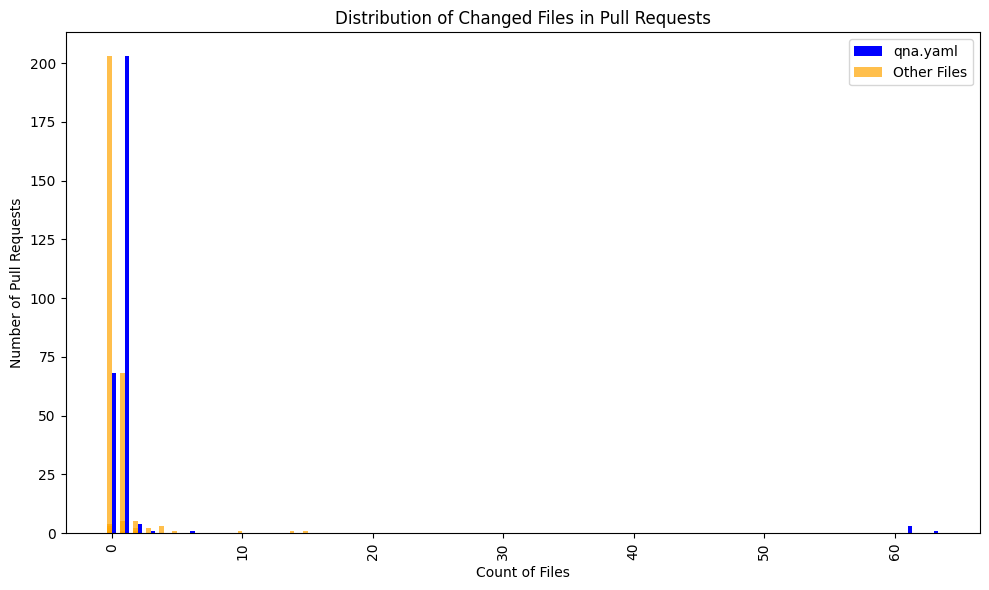

In [20]:
grouped_df = df.groupby(['qna_yaml_count', 'other_files_count']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
bar_width = 0.35
plt.bar(
    grouped_df['qna_yaml_count'] + bar_width / 2,
    grouped_df['count'],
    color='blue',
    label='qna.yaml',
    width=bar_width
)
plt.bar(
    grouped_df['other_files_count'] - bar_width / 2,
    grouped_df['count'],
    color='orange',
    label='Other Files',
    width=bar_width,
    alpha=0.7
)

plt.xlabel('Count of Files')
plt.ylabel('Number of Pull Requests')
plt.title('Distribution of Changed Files in Pull Requests')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.legend()
plt.tight_layout()
plt.show()

In [106]:
mean_qna_count = df['qna_yaml_count'].mean()
median_qna_count = df['qna_yaml_count'].median()
print(f'Mean number of qna.yaml files added in each PR: {mean_qna_count}')
print(f'Median number of qna.yaml files added in each PR: {median_qna_count}')

Mean number of qna.yaml files added in each PR: 1.7704918032786885
Median number of qna.yaml files added in each PR: 1.0


In [24]:
single_qna_count = (df['qna_yaml_count'] == 1).sum()
multiple_qna_count = (df['qna_yaml_count'] > 1).sum()
average_qna_single = df[df['qna_yaml_count'] == 1]['size'].mean()
average_qna_multiple = df[df['qna_yaml_count'] > 1]['size'].mean()

print(f'Number of PRs adding only one qna.yaml: {single_qna_count}')
print(f'Number of PRs adding more than one qna.yaml: {multiple_qna_count}')
print(f'Average size (additions + deletions) of PRs adding only one qna.yaml: {average_qna_single:.2f}')
print(f'Average size of PRs (additions + deletions) adding more than one qna.yaml: {average_qna_multiple:.2f}')


Number of PRs adding only one qna.yaml: 210
Number of PRs adding more than one qna.yaml: 13
Average size (additions + deletions) of PRs adding only one qna.yaml: 80.78
Average size of PRs (additions + deletions) adding more than one qna.yaml: 835.31


## What are the paths that are modified across PRs in the changed qna files?

In [53]:
from collections import Counter

all_paths = []
for files in df['changed_files']:
    for file in files:
        if file.endswith('qna.yaml'):
            all_paths.append(file)

path_counter = Counter(all_paths)

root_dirs = [path.split('/')[0] for path in path_counter.keys()]

root_dir_counts = Counter(root_dirs)

print("Most common root directories:")
for root_dir, count in root_dir_counts.most_common():
    print(f"{root_dir}: {count}")

compositional_skills_count = sum(1 for path in all_paths if "compositional_skills" in path)
freeform_count = sum(1 for path in all_paths if "compositional_skills" in path and "freeform" in path)
grounded_count = sum(1 for path in all_paths if "compositional_skills" in path and "grounded" in path)
knowledge_count = sum(1 for path in all_paths if "knowledge" in path)

print(f"Number of changed files modifying 'compositional_skills' folder: {compositional_skills_count}")
print(f"Number of changed files modifying 'freeform' subdirectory: {freeform_count}")
print(f"Number of changed files modifying 'grounded' subdirectory: {grounded_count}")
print(f"Number of changed files modifying 'knowledge' folder: {knowledge_count}")

Most common root directories:
compositional_skills: 260
knowledge: 5
technical_skills: 1
Number of changed files modifying 'compositional_skills' folder: 530
Number of changed files modifying 'freeform' subdirectory: 281
Number of changed files modifying 'grounded' subdirectory: 81
Number of changed files modifying 'knowledge' folder: 11


In [60]:
total_open_prs = 0
total_merged_prs = 0
open_with_approvals = 0
merged_with_approvals = 0

open_approvals_count = {}
merged_approvals_count = {}

for index, row in df.iterrows():
    if pd.isna(row['closed_at']):
        total_open_prs += 1
        if row['reviews'] > 0 and row['interactions'] == row['reviews']:
            open_with_approvals += 1
            if row['reviews'] not in open_approvals_count:
                open_approvals_count[row['reviews']] = 1
            else:
                open_approvals_count[row['reviews']] += 1
    elif pd.notna(row['merged_at']):
        total_merged_prs += 1
        if row['reviews'] > 0 and row['interactions'] == row['reviews']:
            merged_with_approvals += 1
            if row['reviews'] not in merged_approvals_count:
                merged_approvals_count[row['reviews']] = 1
            else:
                merged_approvals_count[row['reviews']] += 1

print("\n Total open PRs:", total_open_prs)
print("\n Total merged PRs:", total_merged_prs)

print("\n Open PRs with approvals:", open_with_approvals)
print("\n Merged PRs with approvals:", merged_with_approvals)


print("\n Open PRs - Count of Approvals:")
for key, value in open_approvals_count.items():
    print(f"Number of open PRs with {key} approvals: {value}")

print("\n Open PRs - Count of Review Comments:")
for key, value in open_review_comments_count.items():
    print(f"Number of open PRs with {key} review comments: {value}")

print("\n Merged PRs - Count of Approvals:")
for key, value in merged_approvals_count.items():
    print(f"Number of merged PRs with {key} approvals: {value}")

print("\n Merged PRs - Count of Review Comments:")
for key, value in merged_review_comments_count.items():
    print(f"Number of merged PRs with {key} review comments: {value}")



 Total open PRs: 211

 Total merged PRs: 56

 Open PRs with approvals: 6

 Merged PRs with approvals: 4

 Open PRs - Count of Approvals:
Number of open PRs with 3 approvals: 2
Number of open PRs with 2 approvals: 2
Number of open PRs with 5 approvals: 1
Number of open PRs with 1 approvals: 1

 Open PRs - Count of Review Comments:
Number of open PRs with 1 review comments: 49
Number of open PRs with 2 review comments: 18
Number of open PRs with 4 review comments: 6
Number of open PRs with 3 review comments: 13
Number of open PRs with 5 review comments: 2
Number of open PRs with 6 review comments: 2
Number of open PRs with 11 review comments: 1

 Merged PRs - Count of Approvals:
Number of merged PRs with 4 approvals: 1
Number of merged PRs with 10 approvals: 1
Number of merged PRs with 6 approvals: 1
Number of merged PRs with 2 approvals: 1

 Merged PRs - Count of Review Comments:
Number of merged PRs with 1 review comments: 14
Number of merged PRs with 4 review comments: 3
Number of me

## Get PRs which are either approved or merged

For approved and merged PRs capture in a column whether it is a knowledge, freeform or grounded skill.

In [63]:
df['approved_merged'] = 0

for index, row in df.iterrows():
    if pd.notna(row['merged_at']) or (pd.isna(row['closed_at']) and row['reviews'] > 0 and row['interactions'] == row['reviews']):
        df.at[index, 'approved_merged'] = 1

In [64]:
df.head()

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,qna_yaml_count,other_files_count,approved_merged
0,Added a fibonacci skill,**Describe the contribution to the taxonomy**\...,18,rokkbert,2024-03-11 14:14:00+00:00,NaT,None,NaT,1,1,0,0,[],[8f431a034c6c43352967f03c493315843f54a1d6],[compositional_skills/extraction/inference/qua...,1,0,0
1,Add instructions how to write devstack plugins,**Describe the contribution to the taxonomy**\...,178,slawqo,2024-03-11 13:53:28+00:00,NaT,None,NaT,1,1,0,0,[],[70ec61de11fd965d79589b704d22ef86df606954],[compositional_skills/writing/freeform/technic...,1,0,0
2,Support exceptions def,If your PR is related to a contribution to the...,63,r2munz,2024-03-11 13:44:08+00:00,NaT,None,NaT,5,1,0,0,[],"[f6d10ba52de5bf854aabd483745d2e3794cc49fc, 98c...",[compositional_skills/writing/freeform/technic...,1,0,0
3,Support exceptions def,If your PR is related to a contribution to the...,63,r2munz,2024-03-11 13:39:55+00:00,2024-03-11 13:42:03+00:00,r2munz,NaT,5,1,0,0,[],"[f6d10ba52de5bf854aabd483745d2e3794cc49fc, 98c...",[compositional_skills/writing/freeform/technic...,1,0,0
4,Add new skill - character counting,If your PR is related to a contribution to the...,19,jridky,2024-03-11 13:30:58+00:00,NaT,None,NaT,1,1,1,0,[],[aa24b5ce992b7bc43c047df9e2e3b2267c968c68],[compositional_skills/extraction/inference/qua...,1,0,0


In [91]:
def get_skill_type(files):
    skill_types = []
    for file in files:
        if 'knowledge' in file:
            skill_types.append('knowledge')
        elif 'freeform' in file:
            skill_types.append('freeform')
        elif 'grounded' in file:
            skill_types.append('grounded')
        else:
            skill_types.append('other')
    return skill_types

df['type'] = df['changed_files'].apply(get_skill_type)

approved_merged_subset = df[(df['approved_merged'] == 1) & (~df['type'].apply(lambda x: 'other' in x and len(set(x)) == 1))]

In [92]:
print("Number of PRs that are approved or have already been merged that either contribute a knowledge or skill is", len(approved_merged_subset))

Number of PRs that are approved or have already been merged that either contribute a knowledge or skill is 10


In [94]:
approved_merged_subset.head()

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,qna_yaml_count,other_files_count,approved_merged,type
39,Add another example to puns/qna.yaml,If your PR is related to a contribution to the...,8,mosesmuir,2024-03-09 21:36:41+00:00,NaT,None,NaT,1,1,3,3,[triage-requested-changes],[3db6728b18270567ace832d5ed71ccbd94691408],[compositional_skills/writing/freeform/jokes/p...,1,0,1,[freeform]
74,Add skill to discussing how to parse Directory...,it works\r\n\r\nIf your PR is related to a con...,14,mreynolds389,2024-03-08 19:29:38+00:00,NaT,None,NaT,1,1,2,2,[triage-rejected],[3be5868f0d1f2c1655b83b8e8039c38a15db947c],[compositional_skills/writing/freeform/technic...,1,0,1,[freeform]
118,Add correct response for the question: How do ...,If your PR is related to a contribution to the...,46,nickclifton,2024-03-08 11:58:10+00:00,NaT,None,NaT,3,1,2,2,[],"[5989ebcf5a028e9cd693bdb4b1327f2efcfdcf6c, f6e...",[compositional_skills/writing/freeform/technic...,1,0,1,[freeform]
201,Add more examples to puns/qna.yaml,If your PR is related to a contribution to the...,104,bh1000,2024-03-06 20:00:04+00:00,NaT,None,NaT,1,1,5,5,"[triage-requested-changes, skill]",[b80ced6d28207b5bd02513faae2289d9f777c54b],[compositional_skills/writing/freeform/jokes/p...,1,0,1,[freeform]
255,add a man page writing skill,**Describe the contribution**\r\n\r\nThis one ...,1231,goern,2024-03-05 13:01:55+00:00,NaT,None,NaT,1,1,1,1,[skill],[c72d751e9f00139bab874278d13653f2306afa81],[compositional_skills/writing/freeform/technic...,1,0,1,[freeform]


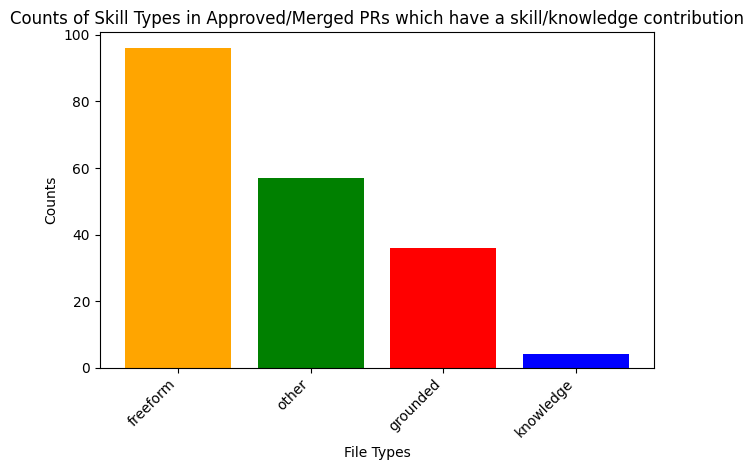

In [105]:
skill_types_count = approved_merged_subset['type'].explode().value_counts()

plt.bar(skill_types_count.index, skill_types_count.values, color=['orange', 'green', 'red', 'blue'])
plt.xlabel('File Types')
plt.ylabel('Counts')
plt.title('Counts of Skill Types in Approved/Merged PRs which have a skill/knowledge contribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## TODO: From this above dataset, use the model and a simple prompt to classify it as a knowledge, skill (freeform or grounded)